<a href="https://colab.research.google.com/github/musandur/ML-Projects/blob/main/Instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>>>>>**Multi-channel instance segmentation from scratch**
******

In [1]:
import json
import cv2
import os
import skimage
%matplotlib inline
from matplotlib import pyplot as plt
import skimage.io 
import numpy as np
from numpy import expand_dims
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa
import sys


In [2]:
from google.colab import drive
drive.mount('/content/drive')
#-----Unzip my dataset from GC (Google Colab)----'
#!unzip -uq "/content/drive/MyDrive/test_minidataset.zip" -d "/content/drive/MyDrive/"


Mounted at /content/drive


In [3]:
#!unzip -uq "/content/drive/MyDrive/Config.zip" -d "/content/drive/MyDrive/"


In [4]:
#!unzip -uq "/content/drive/MyDrive/mydataset.zip" -d "/content/drive/MyDrive/"


In [5]:
sys.path.append('/content/drive/MyDrive')

In [6]:
from Config import config

In [7]:
PATH = '/content/drive/MyDrive/test_minidataset/'

**Introduction:**
We start with a small sample of  5 images that we will use to illustrate all the internal custom functions that we will develop, including image augmentation, multi-channel creation.

In [8]:
IMG_PATH = PATH + 'images/'
ANNOT_PATH = PATH + 'annotated/'
IMG_LIST = sorted(next(os.walk(IMG_PATH))[2], key=lambda x: int(x.split('.')[0]))
ANNOT_LIST = sorted(next(os.walk(ANNOT_PATH))[2], key=lambda x: int(x.split('.')[0]))

print(IMG_LIST)
print(ANNOT_LIST)

['1.png', '2.png', '3.png', '4.png', '5.png']
['1.json', '2.json', '3.json', '4.json', '5.json']


In [9]:
# the hues and the labels
hues = {'lcell':60,
        'rcell':150}
labels = sorted(hues.keys())
print(labels)

['lcell', 'rcell']


In [10]:
def get_annot_dicts(ann_path):
    annotations = json.load(open(ann_path))
    annots = annotations.values()
    return annots

>>>**Create the multi-channel masks given the dataset and their corresponding json annotations**

In [11]:
def create_multi_masks(img, annots):

    #print(img.shape)
    img = img[:,:,:3]   #test_image_rgb = test_image[:,:,:3]
    #print(img.shape)
    
    # now we collect the labels and their corresponding polygon shapes

    for a in annots:
        lbls = [r['region_attributes']['labels'] for r in a['regions']]
        polygons = [ [r['shape_attributes']['all_points_x'], r['shape_attributes']['all_points_y']] 
                    for r in a['regions'] ]
    

    # now build a list of polygon arrays
    poly = [np.array(r, dtype=np.int32) for r in polygons]
    s_poly = [expand_dims(r.transpose(), 0) for r in poly]
    # now associate a label to its corresponding polygon array
    label2poly = dict(zip(lbls, s_poly))

    # build the background class
    background = np.zeros([img.shape[0], img.shape[1]], dtype=np.float32)
    #background = np.zeros(img.shape, dtype=np.float32)

    # initialize the class channel
    channels = []
    for i, label in  enumerate(labels):
        
        blank = np.zeros([img.shape[0], img.shape[1]], dtype=np.float32)
        #blank = np.zeros(img.shape, dtype=np.float32)

        
        if label in lbls:
            cv2.fillPoly(blank, label2poly[label], 255)
            cv2.fillPoly(background, label2poly[label], 255)
        
        channels.append(blank)

    _, thres = cv2.threshold(background, 127, 255, cv2.THRESH_BINARY_INV)
    channels.append(thres)

    Y = np.stack(channels, axis=2)
    
    return Y




(256, 256, 3)


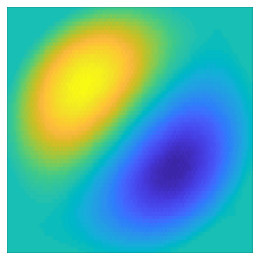

(256, 256)
(256, 256)
(256, 256)


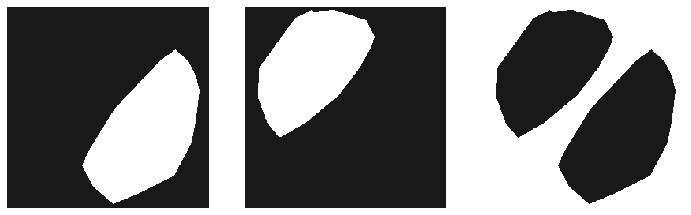

In [12]:
##------------------------Test the function ---------------------------##
    
for im_flnm, ann_flnm in zip(IMG_LIST, ANNOT_LIST):
    img = skimage.io.imread(os.path.join(IMG_PATH, im_flnm))
    ann_path = os.path.join(ANNOT_PATH, ann_flnm)
    annots = get_annot_dicts(ann_path) 
    YY = create_multi_masks(img, annots)
    
    break
print(YY.shape)
skimage.io.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(13, 13))
for i in range(YY.shape[2]):
    plt.subplot(1, 4, i+1)
    mask = YY[:,:,i]/255
    print(mask.shape)
    skimage.io.imshow(mask, cmap='gray', alpha=.9)
    plt.axis('off')


>>>>>**Create multi-channel masks with a Hueing technique**

In [13]:
def draw_multi_masks(img, annots):
    
    img = img[:,:,:3]
    blank = np.zeros(img.shape, dtype=np.uint8)

    # now we collect the labels and their corresponding polygon shapes
    for a in annots:
        lbls = [r['region_attributes']['labels'] for r in a['regions']]
        polygons = [ [r['shape_attributes']['all_points_x'], r['shape_attributes']['all_points_y']] 
                    for r in a['regions'] ]
    

    # now build a list of polygon arrays
    poly = [np.array(r, dtype=np.int32) for r in polygons]
    s_poly = [expand_dims(r.transpose(), 0) for r in poly]
    # now associate a label to its corresponding polygon array
    label2poly = dict(zip(lbls, s_poly))
    
    for i, label in enumerate(labels):
        
        if label in lbls:
            cv2.fillPoly(blank, label2poly[label], (hues[label], 255, 255))
            
    return cv2.cvtColor(blank, cv2.COLOR_HSV2RGB)

In [14]:
# Test the Hue mask
def display_image_and_channels(img_filename, annot_filename):
    img = skimage.io.imread(os.path.join(IMG_PATH, img_filename))
    #print(img.shape)
    ann_path = os.path.join(ANNOT_PATH, annot_filename)
    annots = get_annot_dicts(ann_path)
    skimage.io.imshow(img)
    plt.axis('off')
    plt.show()
    im_color = draw_multi_masks(img, annots)
    display(Image.fromarray(im_color))




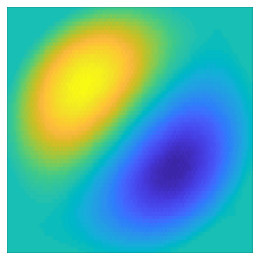

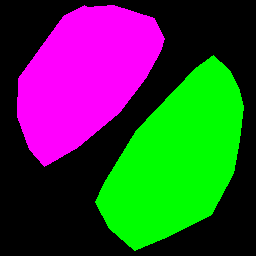

In [15]:
k = 0
display_image_and_channels(IMG_LIST[k], ANNOT_LIST[k])

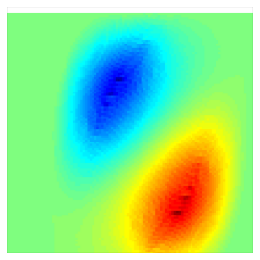

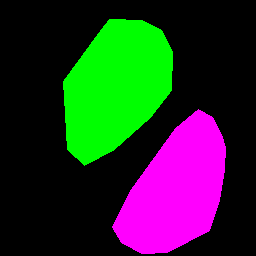

In [16]:
k = 1
display_image_and_channels(IMG_LIST[k], ANNOT_LIST[k])

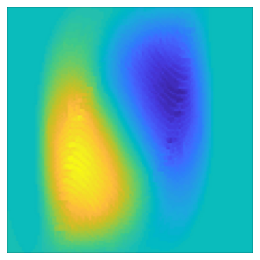

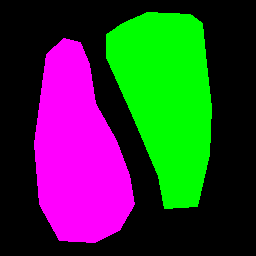

In [17]:
k = 2
display_image_and_channels(IMG_LIST[k], ANNOT_LIST[k])

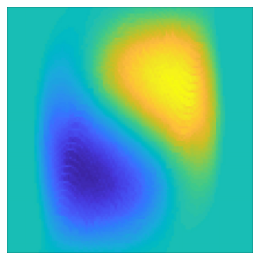

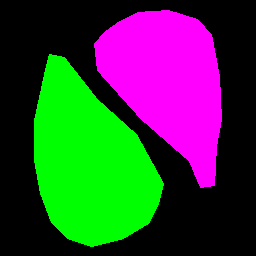

In [18]:
k = 3
display_image_and_channels(IMG_LIST[k], ANNOT_LIST[k])

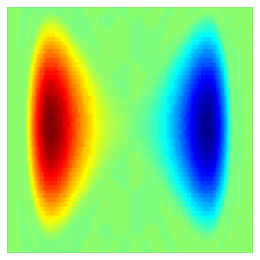

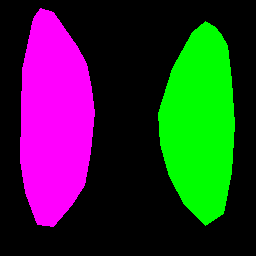

In [19]:
k = 4
display_image_and_channels(IMG_LIST[k], ANNOT_LIST[k])

>>>>>>>**Custom Image augmentation procedure**

In [20]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Multiply((1.2, 1.1)),
    iaa.Affine(
        rotate=(-90, 90)
    ),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 1))
    )
], random_order=True)

seq_det = seq.to_deterministic()




def augment_poly(image_path, ann_path):
    
    annotations = json.load(open(ann_path))
    annots = annotations.values()
    points = []
    aug_shape_dicts = []
    j = 0
    # augment the image
    img = skimage.io.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_aug = seq_det.augment_image(img)
    
    for shape in annots:
        for shape_regions in shape['regions']:
            _d = {}
            _d['labels'] = shape_regions['region_attributes']['labels']
            _d['index'] = (j, j + len(shape_regions['shape_attributes']['all_points_x']))
            aug_shape_dicts.append(_d)

            j += len(shape_regions['shape_attributes']['all_points_x'])
            
            for i in range(len(shape_regions['shape_attributes']['all_points_x'])):
                points.append(ia.Keypoint(x=shape_regions['shape_attributes']['all_points_x'][i], 
                                          y=shape_regions['shape_attributes']['all_points_y'][i]))
                
            
            

            keypoints = ia.KeypointsOnImage(points, shape=(img.shape[0], img.shape[1], 3))
            keypoints_aug = seq_det.augment_keypoints([keypoints])[0]
            # collect the augmented data and set them back into the annotation
            aug_points_x = []
            aug_points_y = []
            all_points = []
            
        for i, shape_aug in enumerate(aug_shape_dicts):
            start, end = shape_aug['index']
            
            for keypoint in keypoints_aug.keypoints[start:end]:
                aug_points_x.append(keypoint.x)
                aug_points_y.append(keypoint.y)
            
            shape['regions'][i]['shape_attributes']['all_points_x'] = aug_points_x
            shape['regions'][i]['shape_attributes']['all_points_y'] = aug_points_y
            aug_points_x = []
            aug_points_y = []
            
        aug_annots = {'rename': shape}
    
    return image_aug, aug_annots.values()

        

In [21]:
def display_augmented_images_and_channels(img_filename, annot_filename):
  # pick an image and its json file

  # image
  imgg_path = os.path.join(IMG_PATH, img_filename)
  img = skimage.io.imread(imgg_path)
  skimage.io.imshow(img)
  plt.axis('off')
  plt.show()
  
  # annotation
  annt_path = os.path.join(ANNOT_PATH, annot_filename)

  # augmenting the image
  img_augg, augg_annots = augment_poly(imgg_path, annt_path)
  plt.imshow(img_augg)
  plt.axis('off')
  plt.show()

  # display the hued channels
  im_color = draw_multi_masks(img_augg, augg_annots)
  print(im_color.shape)
  display(Image.fromarray(im_color))
  #plt.imshow(Image.fromarray(im_color))


  






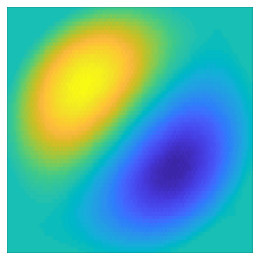

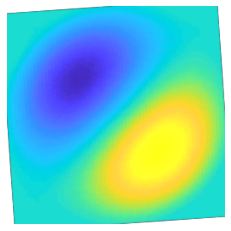

(256, 256, 3)


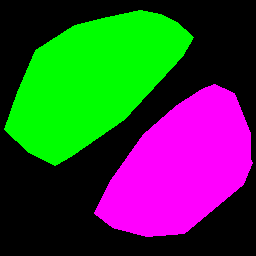

In [22]:
k = 0
display_augmented_images_and_channels(IMG_LIST[k], ANNOT_LIST[k])

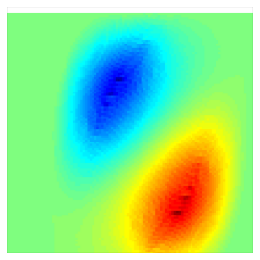

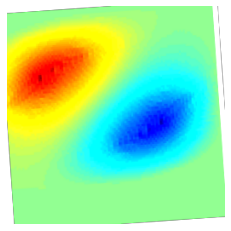

(256, 256, 3)


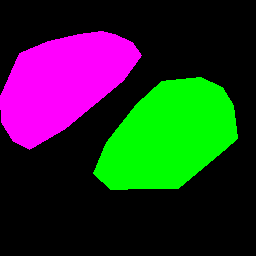

In [23]:
k = 1
display_augmented_images_and_channels(IMG_LIST[k], ANNOT_LIST[k])

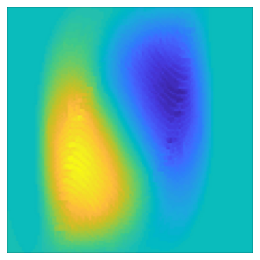

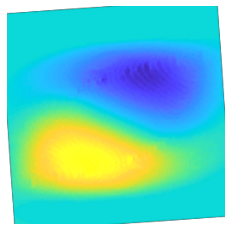

(256, 256, 3)


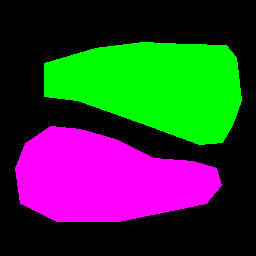

In [24]:
k = 2
display_augmented_images_and_channels(IMG_LIST[k], ANNOT_LIST[k])

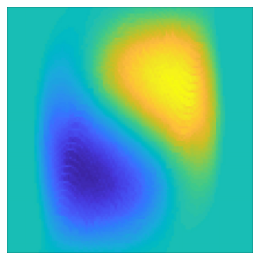

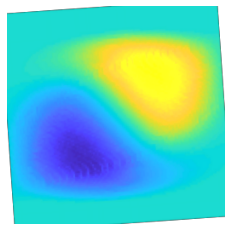

(256, 256, 3)


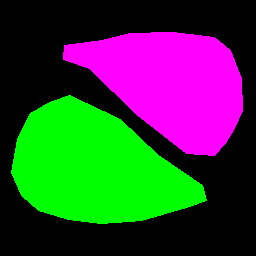

In [25]:
k = 3
display_augmented_images_and_channels(IMG_LIST[k], ANNOT_LIST[k])

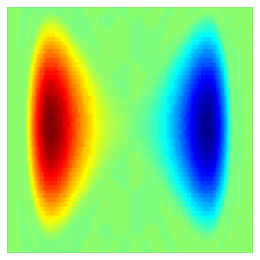

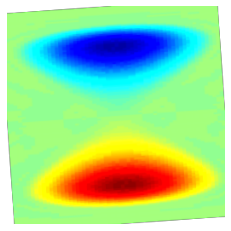

(256, 256, 3)


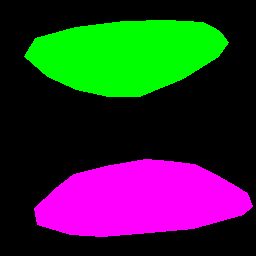

In [26]:
k = 4
display_augmented_images_and_channels(IMG_LIST[k], ANNOT_LIST[k])

In [27]:
import numpy as np
import pickle
import os 
from PIL import Image
#from config import imshape, n_classes, labels, model_name
import imgaug as ia
from imgaug import augmenters as iaa
import cv2
import json
import tensorflow as tf


>>>>>>>**Custom data Generator:**

Now we start the training section. We then begin with building a custom Datagenerator for image segmentation.

In [28]:
class DataGenerator(tf.keras.utils.Sequence):
  # Generates data for Keras
  def __init__(self, image_paths, annot_paths, batch_size=32, shuffle=True, augment=False):
    self.image_paths = image_paths
    self.annot_paths = annot_paths
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.augment = augment
    self.on_epoch_end()

  def __len__(self):
    # Denotes the number of batches
    return int(np.floor(len(self.image_paths) / self.batch_size))


  def __getitem__(self, index):
    # Generates indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    image_paths = [self.image_paths[k] for k in indexes]
    annot_paths = [self.annot_paths[k] for k in indexes]
    
    X, y = self.__data_generation(image_paths, annot_paths)

    return X, y


  def on_epoch_end(self):
    # Updates indexes after each epoch
    self.indexes = np.arange(len(self.image_paths))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  
  def get_annot_dicts(self, ann_path):
    # Extract the dictionary of coordinates 
    # from our json files
    annotations = json.load(open(ann_path))
    annots = annotations.values()
    return annots

  def create_binary_mask(self, img, annots):
    
    #Create a binary mask in case of a semantic segmentation task'

    # Now we collect the labels and their corresponding polygon shapes
    #print(img.shape)
    img = img[:,:,:3]  
    #print(img.shape)

    for a in annots:
        lbls = [r['region_attributes']['labels'] for r in a['regions']]
        polygons = [ [r['shape_attributes']['all_points_x'], r['shape_attributes']['all_points_y']] 
                    for r in a['regions'] ]
    #print(lbls)
    #print(polygons)

    # Now build a list of polygon arrays
    poly = [np.array(r, dtype=np.int32) for r in polygons]
    s_poly = [expand_dims(r.transpose(), 0) for r in poly]
    # now associate a label to its corresponding polygon array
    label2poly = dict(zip(lbls, s_poly))

    blank = np.zeros([img.shape[0], img.shape[1]], dtype=np.float32)

    for i, label in  enumerate(labels):
        
        cv2.fillPoly(blank, label2poly[label], 255)
        


    return blank




  def create_multi_masks(self, img, annots):
    
    #Create a multi-channel masks for instance segmentation tasks'

    #print(img.shape)
    img = img[:,:,:3]   #test_image_rgb = test_image[:,:,:3]
    #print(img.shape)
    
    # Now we collect the labels and their corresponding polygon shapes

    for a in annots:
        lbls = [r['region_attributes']['labels'] for r in a['regions']]
        polygons = [ [r['shape_attributes']['all_points_x'], r['shape_attributes']['all_points_y']] 
                    for r in a['regions'] ]
    

    # Now build a list of polygon arrays
    poly = [np.array(r, dtype=np.int32) for r in polygons]
    s_poly = [expand_dims(r.transpose(), 0) for r in poly]
    # now associate a label to its corresponding polygon array
    label2poly = dict(zip(lbls, s_poly))

    # build the background class
    background = np.zeros([img.shape[0], img.shape[1]], dtype=np.float32)
    #background = np.zeros(img.shape, dtype=np.float32)

    # initialize the class channel
    channels = []
    for i, label in  enumerate(labels):
        
        blank = np.zeros([img.shape[0], img.shape[1]], dtype=np.float32)
        #blank = np.zeros(img.shape, dtype=np.float32)

        
        if label in lbls:
            cv2.fillPoly(blank, label2poly[label], 255)
            cv2.fillPoly(background, label2poly[label], 255)
        
        channels.append(blank)

    _, thres = cv2.threshold(background, 127, 255, cv2.THRESH_BINARY_INV)
    channels.append(thres)

    Y = np.stack(channels, axis=2)
    
    return Y



  def augment_poly(self, image_path, ann_path):
    'A custom data augmention tasks'
    'It helps build a more robust model' 
    'It also helps increase the size of dataset'
    
    annotations = json.load(open(ann_path))
    annots = annotations.values()
    points = []
    aug_shape_dicts = []
    j = 0
    # augment the image
    img = skimage.io.imread(image_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_aug = seq_det.augment_image(img)
    
    for shape in annots:
        for shape_regions in shape['regions']:
            _d = {}
            _d['labels'] = shape_regions['region_attributes']['labels']
            _d['index'] = (j, j + len(shape_regions['shape_attributes']['all_points_x']))
            aug_shape_dicts.append(_d)

            j += len(shape_regions['shape_attributes']['all_points_x'])
            
            for i in range(len(shape_regions['shape_attributes']['all_points_x'])):
                points.append(ia.Keypoint(x=shape_regions['shape_attributes']['all_points_x'][i], 
                                          y=shape_regions['shape_attributes']['all_points_y'][i]))
                
            
            

            keypoints = ia.KeypointsOnImage(points, shape=(img.shape[0], img.shape[1], 3))
            keypoints_aug = seq_det.augment_keypoints([keypoints])[0]
            # collect the augmented data and set them back into the annotation
            aug_points_x = []
            aug_points_y = []
            all_points = []
            
        for i, shape_aug in enumerate(aug_shape_dicts):
            start, end = shape_aug['index']
            
            for keypoint in keypoints_aug.keypoints[start:end]:
                aug_points_x.append(keypoint.x)
                aug_points_y.append(keypoint.y)
            
            shape['regions'][i]['shape_attributes']['all_points_x'] = aug_points_x
            shape['regions'][i]['shape_attributes']['all_points_y'] = aug_points_y
            aug_points_x = []
            aug_points_y = []
            
        aug_annots = {'rename': shape}
    
    return image_aug, aug_annots.values()

  def __data_generation(self, image_paths, annot_paths):

    X = np.empty((self.batch_size, imshape[0], imshape[1], imshape[2]), dtype=np.float32)
    Y = np.empty((self.batch_size, imshape[0], imshape[1], n_classes), dtype=np.float32)

    for i, (im_path, annot_path) in enumerate(zip(image_paths, annot_paths)):

      # read image as grayscal or rgb
      if imshape[2] == 1:
        img = cv2.imread(im_path, 0)
        img = np.expand_dims(img, axis=2)
      elif imshape[2] == 3:
        img = cv2.imread(im_path, 1)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      annots = self.get_annot_dicts(annot_path)

      # check for augmentation
      if self.augment:
        img, annots = self.augment_poly(im_path, annot_path)

      # create target masks 
      if n_classes == 1:
        mask = self.create_binary_mask(img, annots)
      elif n_classes > 1:
        mask = self.create_multi_masks(img, annots)
      img = img[:,:,:3]
      #print(img.shape)
      X[i,] = img
      Y[i, ] = mask/255


    return X, Y

  

In [29]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, concatenate, Dropout, Lambda, Conv2DTranspose, Add
from Config.config import imshape, n_classes, model_name, labels
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
import os

>>>>>**Define the U-net CNN model**

In [30]:
def preprocess_input(x):
    x /= 255.
    #x -= 0.5
    #x *= 2.
    return x


def dice(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def unet(pretrained=False, base=4):

    if pretrained:
        path = os.path.join('models', model_name+'.model')
        if os.path.exists(path):
            model = load_model(path, custom_objects={'dice': dice})
            model.summary()
            return model
        else:
            print('Failed to load existing model at: {}'.format(path))

    if n_classes == 1:
        loss = 'binary_crossentropy'
        final_act = 'sigmoid'
    elif n_classes > 1:
        loss = tf.keras.losses.CategoricalCrossentropy()
        final_act = 'softmax'

    b = base
    i = Input((imshape[0], imshape[1], imshape[2]))
    s = Lambda(lambda x: preprocess_input(x)) (i)

    c1 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(2**(b+4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(2**(b+4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(2**(b+3), (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(2**(b+2), (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(2**(b+1), (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(2**b, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    o = Conv2D(n_classes, (1, 1), activation=final_act) (c9)

    model = Model(inputs=i, outputs=o, name=model_name)
    model.compile(optimizer= Adam(1e-5),
                  loss=loss,
                  metrics=[dice])
    

    model.summary()

    return model

>>>>**Loading the training dataset and the masks**

In [31]:
TRAIN_IMG_PATH = '/content/drive/MyDrive/mydataset/train_dataset/images/'
LABEL_PATH = '/content/drive/MyDrive/mydataset/train_dataset/multi_channel_masks/'
ANNOTS = '/content/drive/MyDrive/mydataset/train_dataset/annotated/'

# this is the test dataset that will be used at the end of training
TEST_IMG_PATH =  '/content/drive/MyDrive/mydataset/test_dataset/images/'
test_images = sorted(next(os.walk(TEST_IMG_PATH))[2], key=lambda x: int(x.split('.')[0]) )
test_images_paths = [os.path.join(TEST_IMG_PATH, x) for x in test_images]

#TEST_PATH = '/content/drive/MyDrive/mydataset/test_dataset'

images = sorted(next(os.walk(TRAIN_IMG_PATH))[2], key=lambda x: int(x.split('.')[0]) )
annotations = sorted(next(os.walk(ANNOTS))[2], key=lambda x: int(x.split('.')[0]) )
masks = sorted(next(os.walk(LABEL_PATH))[2], key=lambda x: int(x.split('.')[0]) )

image_paths = [os.path.join(TRAIN_IMG_PATH, x) for x in images]
mask_paths = [os.path.join(LABEL_PATH, x) for x in masks]
annot_paths = [os.path.join(ANNOTS, x) for x in annotations]





>>>>>>**Fit the data in the model for training**

In [32]:
if 'unet' in model_name:
  model = unet(pretrained=False, base=4)

tg = DataGenerator(image_paths=image_paths, annot_paths=annot_paths, batch_size=2, augment=True)

Model: "unet_multi"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
_________________________________________________________________________________________

>>>>>>>>>**Training: Go!**

In [33]:
history = model.fit_generator(generator=tg, steps_per_epoch=len(tg), epochs=900, verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/900
41/41 [==============================] - 66s 1s/step - loss: 1.6876 - dice: 0.3389
Epoch 2/900
41/41 [==============================] - 4s 95ms/step - loss: 1.3907 - dice: 0.3809
Epoch 3/900
41/41 [==============================] - 3s 81ms/step - loss: 1.2441 - dice: 0.4095
Epoch 4/900
41/41 [==============================] - 3s 81ms/step - loss: 1.1473 - dice: 0.4309
Epoch 5/900
41/41 [==============================] - 3s 81ms/step - loss: 1.0553 - dice: 0.4499
Epoch 6/900
41/41 [==============================] - 3s 82ms/step - loss: 0.9744 - dice: 0.4676
Epoch 7/900
41/41 [==============================] - 3s 81ms/step - loss: 0.9032 - dice: 0.4898
Epoch 8/900
41/41 [==============================] - 3s 80ms/step - loss: 0.8355 - dice: 0.5133
Epoch 9/900
41/41 [==============================] - 3s 82ms/step - loss: 0.7735 - dice: 0.5449
Epoch 10/900
41/41 [==============================] - 3s 82ms/step - loss: 0.7259 - dice: 0.5661
Epoch 11/900
41/41 [====================

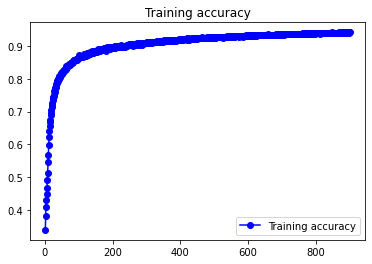

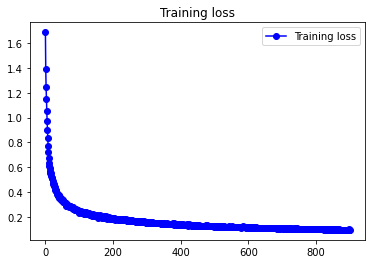

In [34]:
acc = history.history['dice']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

**Sanity check: Use the training data to see if the model has done a good job**

In [37]:
XX_val = np.zeros((10, 256, 256, 3))
YY_val = np.zeros((10, 256, 256, 3))
for i in range(10):
  img = skimage.io.imread(image_paths[i])
  img1 = img[:,:,:3]/255
  img = img[:,:,:3]
  imgg = np.expand_dims(img, 0)
  preds_train_t = model.predict(imgg, verbose=1)
  XX_val[i] = img1
  YY_val[i] =  preds_train_t[0]

1/1 [==============================] - 0s 20ms/step


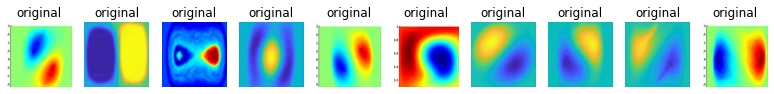

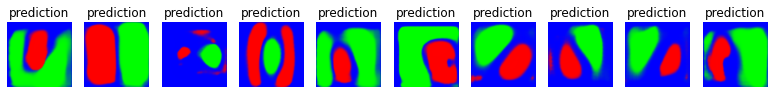

In [38]:
plt.figure(figsize=(15, 15))
for i in range(10):
  plt.subplot(1, 11, i+1)
  plt.imshow(XX_val[i])
  plt.title('original')
  plt.axis('off')
plt.show()

plt.figure(figsize=(15, 15))
for i in range(10):
  plt.subplot(1, 11, i+1)
  plt.imshow(YY_val[i])
  plt.title('prediction')
  plt.axis('off')
plt.show()

*************

**********

*******

>>>>>>**Testing with completely new images!**

Here we will test the performance of our model by feeding it completly new images and see the accurcy of instance segmentation! 

In [39]:
XX_test = np.zeros((len(test_images_paths), 256, 256, 3))
YY_test = np.zeros((len(test_images_paths), 256, 256, 3))
ZZ_test = np.zeros((len(test_images_paths), 256, 256, 3))

for i in range(len(test_images_paths)):
  img = skimage.io.imread(test_images_paths[i])
  img1 = img[:,:,:3]/255
  XX_test[i] = img1 
  img = img[:,:,:3]
  imgg = np.expand_dims(img, 0)
  preds_train_t = model.predict(imgg, verbose=1)
  preds_train_tt = (preds_train_t >0.03).astype(np.float32)
  YY_test[i] =  preds_train_t[0]
  ZZ_test[i] = preds_train_tt[0]




1/1 [==============================] - 0s 19ms/step


In [57]:
def plot_results(k):
  XX = [XX_test[k], YY_test[k], ZZ_test[k]]
  labels = ['original', 'prediction', 'colour refinement']
  plt.figure(figsize=(11, 11))
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(XX[i])
    plt.title(labels[i])
    plt.axis('off')
  plt.show()


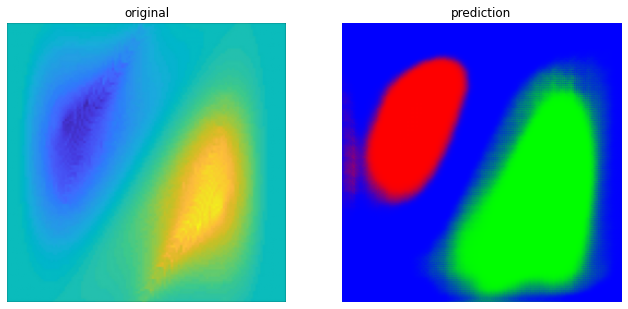

In [58]:
k = 0
plot_results(k)

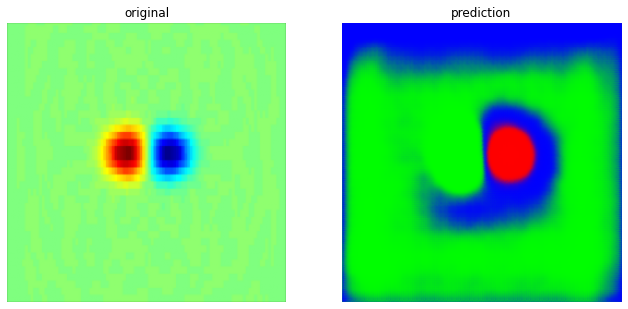

In [59]:
k = 1 
plot_results(k)

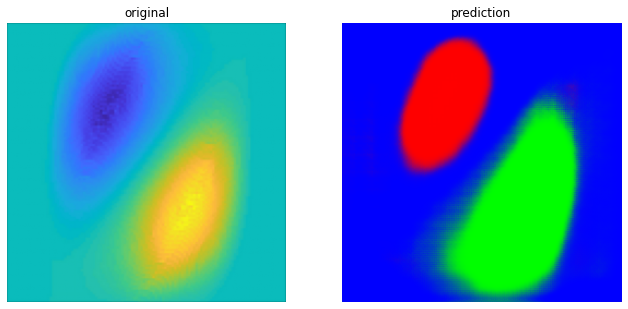

In [60]:
k = 2
plot_results(k)

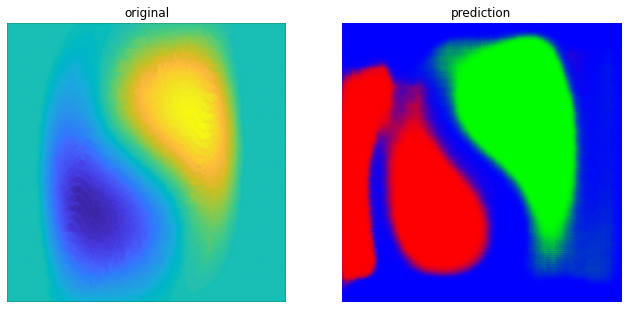

In [61]:
k = 3
plot_results(k)

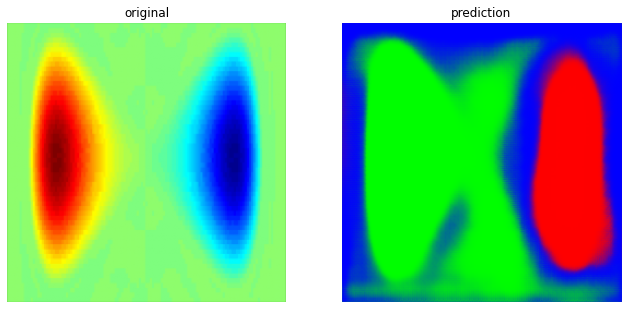

In [62]:
k = 4
plot_results(k)

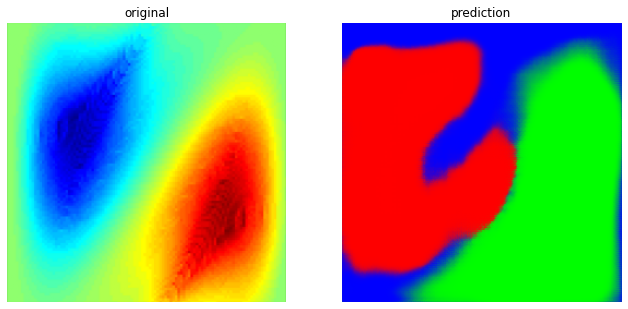

In [63]:
k = 5
plot_results(k)

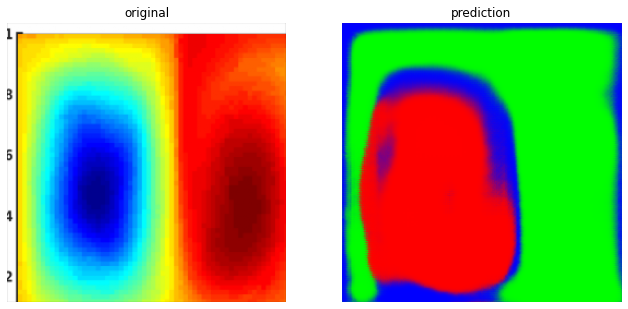

In [64]:
k = 6
plot_results(k)

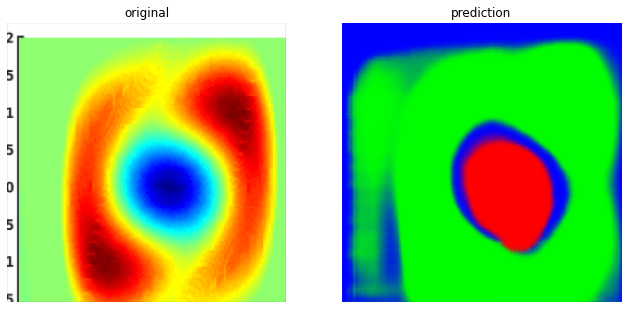

In [65]:
k = 7
plot_results(k)

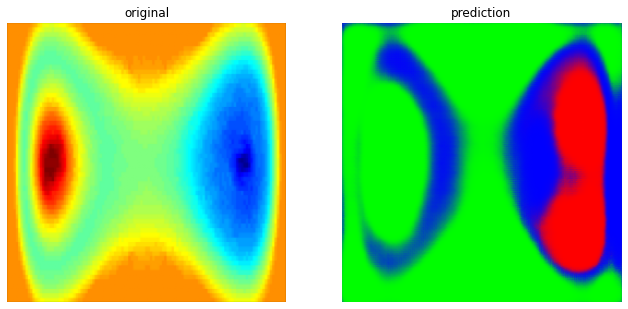

In [66]:
k = 8
plot_results(k)

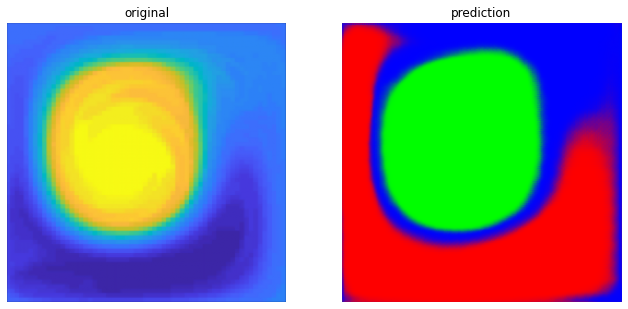

In [67]:
k = 9
plot_results(k)

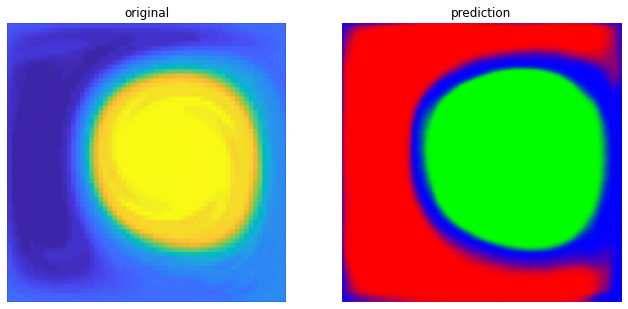

In [68]:
k = 10
plot_results(k)

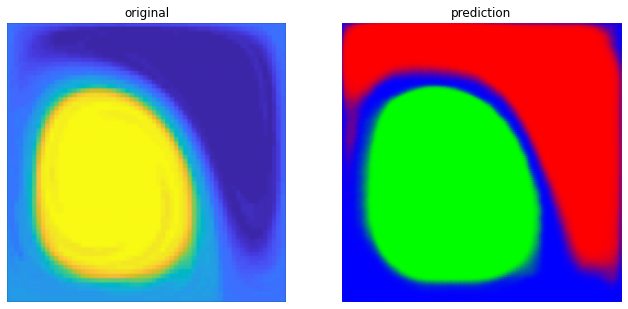

In [69]:
k = 11
plot_results(k)

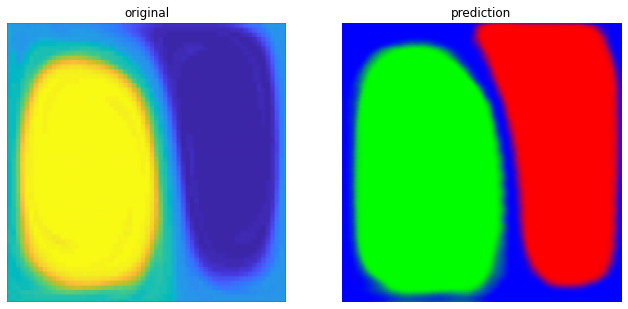

In [70]:
k = 12
plot_results(k)

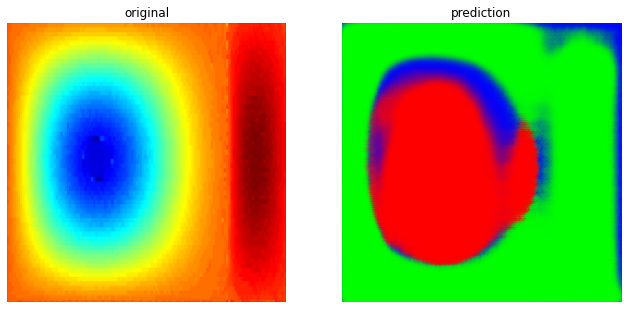

In [71]:
plot_results(13)

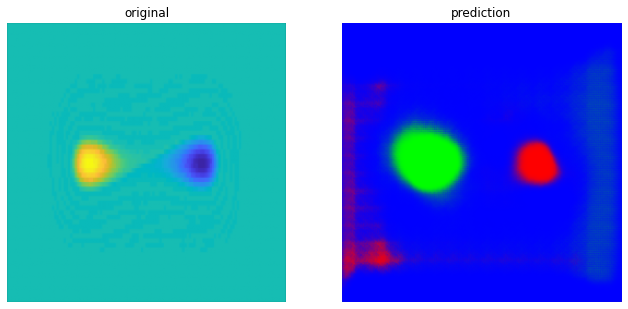

In [72]:
plot_results(14)

**Conclusion:**

We have build an image instance segmentation model using a custom Datagenerator where  we include a custom image augmentation. That is why, our dataset, which is small, could be enlarged using those transformations. The optimization algorithm was executed within 900 epochs. As a result, an accuracy of $94\%$ was reached. That is a good performance, and is illutrated through the predictions of the test dataset. Note that all the work was built from scratch, including the dataset that I have constructed from some mathematical models.